## Combined Notebook ##
Tobias Beidler-Shenk, Nick Usme, Ram Adesara

For our project, we picked three factors that we thought were most important for the determination of a good neighborhood. The Pittsburgh SNAP Census datasets (2010) had all the information we needed, indexed by neighborhood. The factors we chose were:
1. Transportation
2. Health/Safety
3. Housing

For each of these factors, we broke them down further into more variables (for example, transportation was split into public transportation, driver-friendliness, and walking/biking). We then used survey data (we received around 100 responses) to weigh these variables relative to their importance. Here is one question on the survey, as an example:

In [27]:
from IPython.display import Image
Image(url= "surveyq.png", width=800, height=800)

From aggregating all the data, we are able to get average values for the questions in the survey. This question relates to transportation, and the average response for this question was 4.34, meaning transportation's "weight" was 4.34. For each variable, we multiply them by their weight in order to account more for the factors that people find most important.

In [28]:
import pandas as pd
import numpy as np
import geopandas as geo
%matplotlib inline
import matplotlib.pyplot as plt
neighborhoods = geo.read_file("Neighborhoods/Neighborhoods_.shp")
public_safety = pd.read_csv("public_safety.csv", index_col="Neighborhood")
transportation = pd.read_csv('transportation.csv', index_col = "Neighborhood")
weights = pd.read_csv("weights.csv", index_col = "Timestamp")

# Metric #1: Transporation #
First up: measuring the efficacy of a neighborhood's **public transportation**. We only used one column of data for this: the percentage of people who take public transportation to work. The more people who take it to work in a neighborhood, the stronger we consider that neighborhood's public transit routes to be, and so it receives a higher public transit score. Those scores are then multiplied by our public transportation "weight" that we received from the survey.

In [29]:
# Removes percentage signs, so we can order numerically:
count = 0
for x in transportation['Commute to Work: Public Transportation (2010)']:
    x = str(x).rstrip('%')
    transportation.iloc[count, 11] = float(x)
    count+=1

# Displays top 8 scores, after weight:
pt_scores = transportation.sort_values(by=['Commute to Work: Public Transportation (2010)'], ascending = False).iloc[0:, 11:12]
pt_scores["Public Transit Scores"] = np.nan
#transit_scale = 100/pt_scores.iloc[0,0]
for x in range (len(pt_scores)):
    pt_scores.iloc[x,1] = pt_scores.iloc[x,0] * weights.iloc[len(weights)-1, 0]
pt_scores.head(8)

,Commute to Work: Public Transportation (2010),Public Transit Scores
Neighborhood,,
Arlington Heights,88.9,386.255172
Northview Heights,77.4,336.289655
St. Clair,55,238.965517
Middle Hill,48.3,209.855172
Terrace Village,45.2,196.386207
Beltzhoover,43.1,187.262069
Manchester,41.7,181.179310
California-Kirkbride,41,178.137931


Using these scores, we can create a visual representation in geopandas to get a better idea of where our frontrunners are.

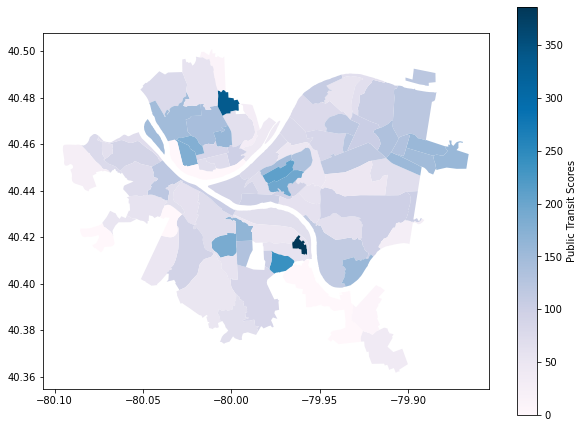

In [30]:
# Geopandas representation
scores1 = pt_scores.groupby("Neighborhood").sum()['Public Transit Scores']
pt_map = neighborhoods.merge(scores1, how='left', left_on='hood', right_on='Neighborhood')
pt_map.plot(column='Public Transit Scores',
                  cmap='PuBu',
                  figsize=(10,7.5), 
                  legend=True,
                  legend_kwds={'label':"Public Transit Scores"})

Geopandas tells us that there are a couple neighborhoods that are great for public transportation, but also that as you get to the outskirts of Pittsburgh, the public transportation is not as strong. This makes sense, as it would make sense for neighborhoods closer to downtown Pittsburgh to be stronger as for public transit. These scores are admittedly not perfect because we are only taking into account one column of data (% people who take PT to work) but it gives us a rough idea of which neighborhoods have strong PT.

Next, we look at how **driver-friendly** each neighborhood is. We take three variables into account here: the street density of each neighborhood (total length of streets for a given area), the percentage of people who drive to work, and the number of residential parking areas afforded to residents of the neighborhood.

In [31]:
# Street Density sorting
street_density = transportation.sort_values(by=['Street Density (st. mi/area sq. mi)'], ascending = False).iloc[0:, 4:5]

# Driving Percentages sorting (removes percentage signs)
count = 0
for x in transportation['Commute to Work: Drive Alone (2010)']:
    x = str(x).rstrip('%')
    transportation.iloc[count, 9] = float(x)
    count+=1
driving_percentages = transportation.sort_values(by=['Commute to Work: Drive Alone (2010)'], ascending = False).iloc[0:, 9:10]

# Parking areas sorting (adds up totals)
for x in range (len(transportation)):
    if (transportation.iloc[x, 7] == "None"):
        transportation.iloc[x, 7] = 0;
    else:
        transportation.iloc[x, 7] = len(str(transportation.iloc[x, 7]).split(','))
parking_available = transportation.sort_values(by=['Res. Permit Parking Area(s)'], ascending = False).iloc[0:, 7:8]

scores_before_scaling = pd.concat([street_density, parking_available, driving_percentages], axis = 1, join='inner')
scores_before_scaling

,Street Density (st. mi/area sq. mi),Res. Permit Parking Area(s),Commute to Work: Drive Alone (2010)
Neighborhood,,,
East Allegheny,71.8,1,44.3
Bluff,50.4,1,25.5
Central Business District,48.2,0,24.8
Knoxville,47.7,0,48.4
Central Northside,47.0,1,47.9
...,...,...,...
East Carnegie,12.9,0,100
Fairywood,9.4,0,42.2
Arlington Heights,8.2,0,11.1


It doesn't make sense to simply add these scores together to recieve a total driving score; for example, the most residential parking areas a neighborhood has is 5. Therefore, we need to scale these scores up relative to one another, so that they each occupy an equal part of the driving score. Then, we multiply the averaged scores by the "driving weight" from our survey to get final driving scores.

In [32]:
# Scales up the values so they each represent an equal part of the score (each out of 100, like percentages)
parking_scale = 100/parking_available.iloc[0]
density_scale = 100/street_density.iloc[0]
driving_scale = 100/driving_percentages.iloc[0]
for x in range (len(parking_available)):
    parking_available.iloc[x] = parking_available.iloc[x] * parking_scale
    street_density.iloc[x] = street_density.iloc[x] * density_scale
    driving_percentages.iloc[x] = driving_percentages.iloc[x] * driving_scale

# Averages the three values for each neighborhood (street density, parking areas available and driving percentages) 
# and multiplies the result by the weight from the survey
driving_scores = pd.concat([street_density, parking_available, driving_percentages], axis = 1, join='inner')
driving_scores["Driving Scores"] = np.nan 
for x in range(len(driving_scores)):
    driving_scores.iloc[x,3] = 0
    for y in range(3):
        driving_scores.iloc[x,3] += driving_scores.iloc[x,y]
    driving_scores.iloc[x,3] = (driving_scores.iloc[x,3]/3) * weights.iloc[len(weights)-1, 1]
    
# Displays top 8 scores, after weight and scaling:
driving_scores.sort_values(by=['Driving Scores'], ascending = False).head(8)

,Street Density (st. mi/area sq. mi),Res. Permit Parking Area(s),Commute to Work: Drive Alone (2010),Driving Scores
Neighborhood,,,,
Shadyside,41.225627,100,44.8,233.066590
East Allegheny,100.000000,20,44.3,205.847126
North Shore,62.534819,20,72,193.612589
Mount Washington,41.782730,40,65,183.900202
Crawford-Roberts,59.888579,20,65.4,182.028220
Bloomfield,62.952646,40,42,181.607338
South Oakland,52.646240,40,46.6,174.457932
Squirrel Hill North,30.222841,60,47.5,172.549307


Graphing these scores with Geopandas:

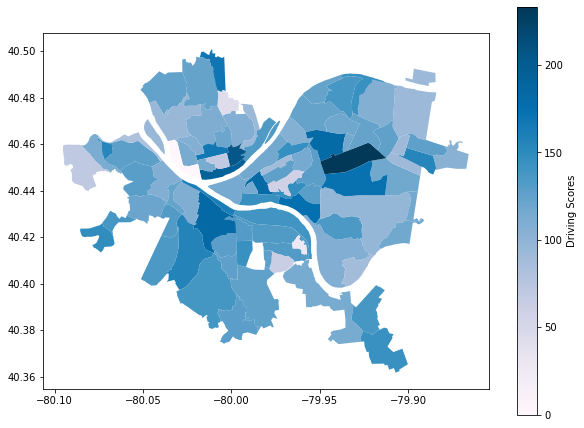

In [33]:
# Geopandas representation
scores2 = driving_scores.groupby("Neighborhood").sum()['Driving Scores']
driving_map = neighborhoods.merge(scores2, how='left', left_on='hood', right_on='Neighborhood')
driving_map.plot(column='Driving Scores',
                  cmap='PuBu',
                  figsize=(10,7.5), 
                  legend=True,
                  legend_kwds={'label':"Driving Scores"}
                  )

This is the result we expected; nearly every neighborhood is somewhat competent as far as drivability. Car owners are everywhere, and so it is really important that any given area can accomodate drivers. **Shadyside** ends up winning by a large margin, mainly due to the amount of residential parking it affords to its residents.

The last factor for the transportation metric that we choose to look at is how good a neighborhood is for walkers/bikers. We take two variables into account here: firstly, the percentage of people who bike to work, and secondly the percentage of people who walk to work. We average these together, after scaling them proportionally to one another as we did for driving scores, and multiply them by the "walking/biking" weight from the survey. 

In [34]:
# Walking scores
count = 0
for x in transportation['Commute to Work: Walk (2010)']:
    x = str(x).rstrip('%')
    transportation.iloc[count, 15] = float(x)
    count+=1
walking = transportation.sort_values(by=['Commute to Work: Walk (2010)'], ascending = False).iloc[0:, 15:16]

# Biking scores
count = 0
for x in transportation['Commute to Work: Bicycle (2010)']:
    x = str(x).rstrip('%')
    transportation.iloc[count, 14] = float(x)
    count+=1
biking = transportation.sort_values(by=['Commute to Work: Bicycle (2010)'], ascending = False).iloc[0:, 14:15]

bw_before_scaling = pd.concat([biking, walking], axis = 1, join='inner')
bw_before_scaling.head(8)

,Commute to Work: Bicycle (2010),Commute to Work: Walk (2010)
Neighborhood,,
Lower Lawrenceville,7.5,13.7
Bloomfield,6.4,18.8
Spring Hill-City View,6.3,4.4
Spring Garden,5.2,12.5
Friendship,4.9,20.1
Greenfield,3.1,6.9
Swisshelm Park,3.1,3
North Oakland,2.9,52.6


Again, we have to scale these columns so they each contribute equally to the score.

In [35]:
# Scales up the values for walking/biking so they each represent an equal part of the score:
walking_scale = 100/walking.iloc[0]
biking_scale = 100/biking.iloc[0]
for x in range (len(walking)):
    walking.iloc[x] = walking.iloc[x] * walking_scale
    biking.iloc[x] = biking.iloc[x] * biking_scale

# Averages the two values for each neighborhood (biking and walking percentages) and multiplies the result by the weight from the survey:
bw_scores = pd.concat([walking, biking], axis = 1, join='inner')
bw_scores["Biking/Walking Scores"] = np.nan 
for x in range(len(bw_scores)):
    bw_scores.iloc[x,2] = 0
    for y in range(2):
        bw_scores.iloc[x,2] += bw_scores.iloc[x,y]
    bw_scores.iloc[x,2] = (bw_scores.iloc[x,2]/2) * weights.iloc[len(weights)-1, 2]

# Displays the top 8 scores, after weight:
bw_scores.sort_values(by=['Biking/Walking Scores'], ascending = False).head(8)

,Commute to Work: Walk (2010),Commute to Work: Bicycle (2010),Biking/Walking Scores
Neighborhood,,,
North Oakland,84.2949,38.6667,266.416667
Lower Lawrenceville,21.9551,100,264.236111
Bloomfield,30.1282,85.3333,250.166667
Central Oakland,100,0,216.666667
Friendship,32.2115,65.3333,211.347222
Spring Hill-City View,7.05128,84,197.277778
Spring Garden,20.0321,69.3333,193.625000
Allegheny Center,70.1923,0,152.083333


Again, we take a look at the Geopandas visual for this metric:

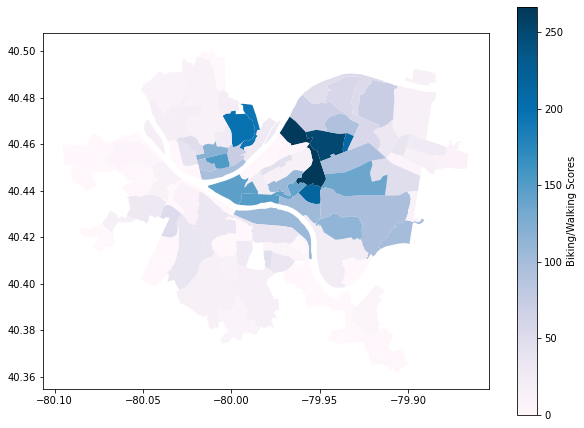

In [36]:
# Geopandas representation
scores3 = bw_scores.groupby("Neighborhood").sum()['Biking/Walking Scores']
bw_map = neighborhoods.merge(scores3, how='left', left_on='hood', right_on='Neighborhood')
bw_map.plot(column='Biking/Walking Scores',
                  cmap='PuBu',
                  figsize=(10,7.5), 
                  legend=True,
                  legend_kwds={'label':"Biking/Walking Scores"}
                  )

This result also makes sense. Neighborhoods closer to downtown are a lot stronger when it comes to walking/biking. As you move toward the outskirts of Pittsburgh, the city starts to look more like a "suburb" in addition to getting hillier, obviously making walking/biking to work more difficult. **North Oakland** takes the lead for this metric.

Now, we combine all three scores into one to make one big "transportation score". Because we have applied weights to each of the metrics, the metrics that scored higher in our survey will contribute more to the final scores. Below are the scores (they were combined into one dataset in the transportation notebook, and transferred into a csv file for the purpose of condensing the combined notebook) in addition to a geopandas graphic.

In [37]:
overall_scores = pd.read_csv('transportation_scores.csv', index_col = 'Neighborhood')
overall_scores.head(8)

,Public Transit Scores,Driving Scores,Biking/Walking Scores,Overall
Neighborhood,,,,
Bloomfield,86.896552,181.607338,250.166667,518.670557
Friendship,123.827586,117.268268,211.347222,452.443076
Lower Lawrenceville,79.075862,107.403371,264.236111,450.715345
North Oakland,49.965517,128.447110,266.416667,444.829294
Shadyside,116.875862,233.066590,94.736111,444.678563
Arlington Heights,386.255172,28.215480,0.000000,414.470653
Central Oakland,57.786207,129.516066,216.666667,403.968940
Northview Heights,336.289655,42.805699,19.791667,398.887021


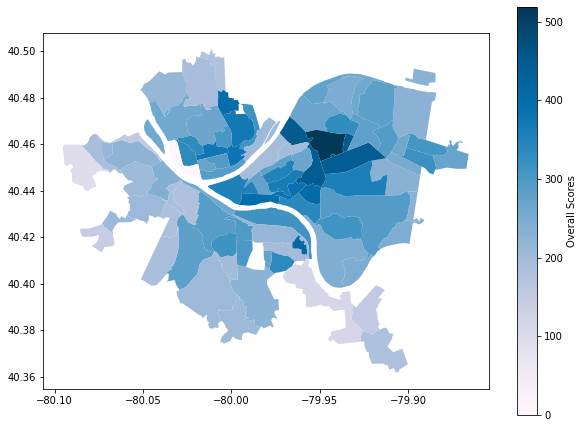

In [38]:
# Geopandas representation
final_scores = overall_scores.groupby("Neighborhood").sum()['Overall']
neighborhoods = geo.read_file("Neighborhoods/Neighborhoods_.shp")
final_map = neighborhoods.merge(final_scores, how='left', left_on='hood', right_on='Neighborhood')
final_map.plot(column='Overall',
                  cmap='PuBu',
                  figsize=(10,7.5), 
                  legend=True,
                  legend_kwds={'label':"Overall Scores"})

For the transportation metric, our three winners are:
1. Bloomfield
2. Friendship
3. Lower Lawrenceville

---

---

# Metric #2: Health and Safety ### 
For our next metric, we are trying to find out which neighborhood is the safest. We will start off by figuring out which neighborhoods are the most theft-free and which are the most drug-free. With these two criteria, we will classify which neighborhood comes on top for "the most safe neighborhood".

---

## Critera one: Most *theft-free*

To begin, I will isolate all theft related crimes per neighborhood. This way I can find which neighborhoods have the most overall theft.

In [39]:
burglaries = public_safety.groupby("Neighborhood").sum()['#Burglary (2010)']
burglaries

Neighborhood
Allegheny Center        8
Allegheny West          6
Allentown              48
Arlington              15
Arlington Heights       5
                       ..
Upper Lawrenceville    24
West End                7
West Oakland           14
Westwood               17
Windgap                 8
Name: #Burglary (2010), Length: 90, dtype: int64

In [40]:
auto_theft = public_safety.groupby("Neighborhood").sum()['#Auto Theft (2010)']
auto_theft

Neighborhood
Allegheny Center        5
Allegheny West          4
Allentown              11
Arlington               7
Arlington Heights       3
                       ..
Upper Lawrenceville    12
West End                3
West Oakland            8
Westwood                6
Windgap                 7
Name: #Auto Theft (2010), Length: 90, dtype: int64

In [41]:
robbery = public_safety.groupby("Neighborhood").sum()['#Robbery (2010)']
robbery

Neighborhood
Allegheny Center        9
Allegheny West          4
Allentown              15
Arlington               8
Arlington Heights       4
                       ..
Upper Lawrenceville    12
West End                2
West Oakland           13
Westwood                1
Windgap                 4
Name: #Robbery (2010), Length: 90, dtype: int64

## Now that we have a rough idea of how many robberies, burglaries, and auto thefts each neighborhood has had, lets combine them altogether to make one "Theft" score for each neighborhood. Let's 

In [42]:
theft = pd.concat([burglaries, auto_theft, robbery], axis = 1, join='inner')
theft["Thefts"] = np.nan
for x in range(len(theft)):
    theft.iloc[x,3] = 0
    for y in range(3):
        theft.iloc[x,3] += theft.iloc[x,y]
theft = theft.sort_values(by=['Thefts'], ascending=True)
theft

,#Burglary (2010),#Auto Theft (2010),#Robbery (2010),Thefts
Neighborhood,,,,
Fairywood,1,0,0,1.0
Chateau,0,2,1,3.0
New Homestead,1,2,0,3.0
Ridgemont,3,0,0,3.0
Chartiers City,2,2,0,4.0
...,...,...,...,...
Bloomfield,70,36,45,151.0
Mount Washington,115,38,22,175.0
South Side Flats,74,56,52,182.0


Just to make it a little easier on the eyes...

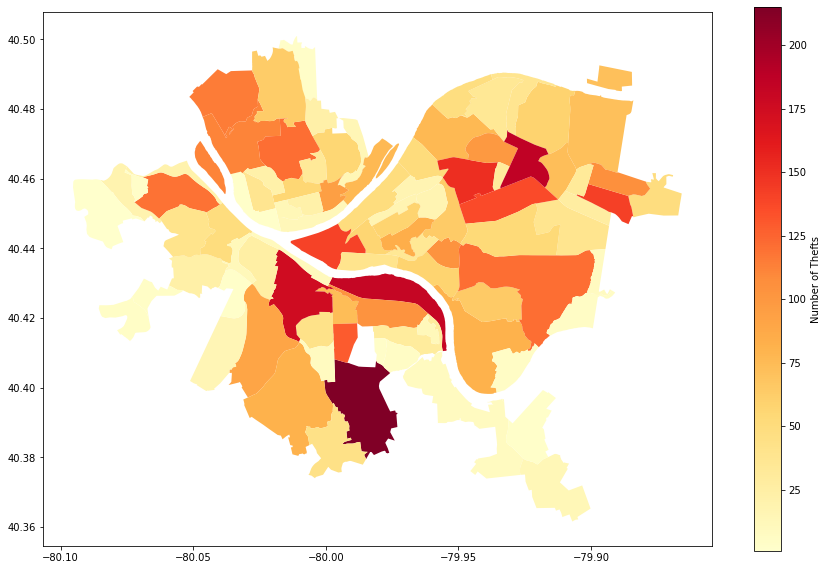

In [43]:
theft_graph = theft.groupby("Neighborhood").sum()['Thefts']
theft_map = neighborhoods.merge(theft_graph, how='left', left_on='hood', right_on='Neighborhood')
theft_map.plot(column='Thefts',
                  cmap='YlOrRd',
                  figsize=(15,10), 
                  legend=True,
                  legend_kwds={'label':"Number of Thefts"}
                  )

---

## Fairywood is looking good! But a theft-free community isn't all that makes for a good neighborhood, lets move on to our "Drug-free" criteria
This one is rather simple: all we have to do its look over the "Drug violations" column in our dataset and boom, there's our "Drug free score". The higher the score, the worse the neighborhood!

In [44]:
drug_vio = public_safety.groupby("Neighborhood").sum()['#Drug Violations (2010)']
drug_vio = drug_vio.sort_values(ascending=False)
drug_vio

Neighborhood
Knoxville           113
Middle Hill         102
Crawford-Roberts     90
Perry South          87
East Allegheny       73
                   ... 
St. Clair             0
Swisshelm Park        0
Lincoln Place         0
East Carnegie         0
Fairywood             0
Name: #Drug Violations (2010), Length: 90, dtype: int64

## Lets use a map to make things a little more clear...

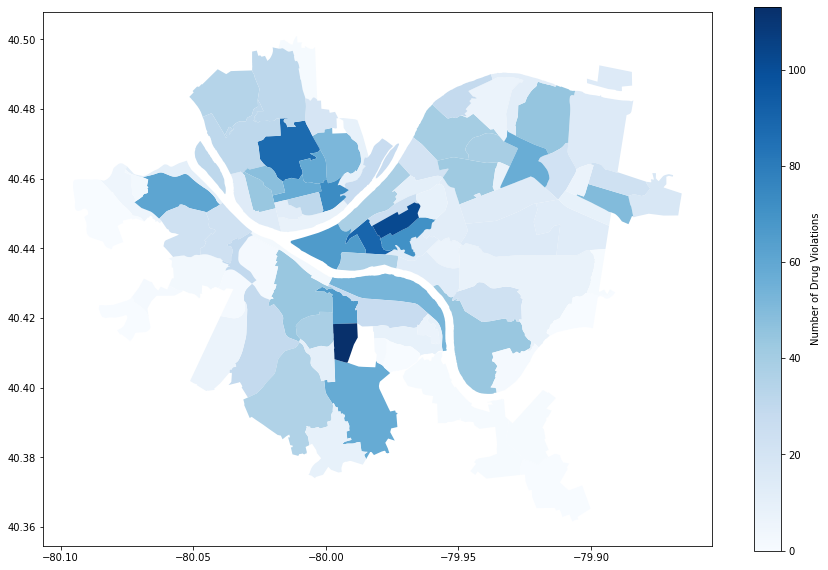

In [45]:
drug_map = neighborhoods.merge(drug_vio, how='left', left_on='hood', right_on='Neighborhood')
drug_map.plot(column='#Drug Violations (2010)',
                  cmap='Blues',
                  figsize=(15,10), 
                  legend=True,
                  legend_kwds={'label':"Number of Drug Violations"}
                  )

---

## Now that all thats taken care of... *the moment we've all be waiting for...*
Lets now make a table that allows us to see each neighborhoods theft-free score and drug-free score. Remember, the larger the score, the worse the neighborhood.

In [57]:
thefts = theft.groupby("Neighborhood").sum()['Thefts']
best_neigh = pd.concat([thefts, drug_vio], axis = 1, join='inner')
best_neigh["Crime Scores"] = np.nan
for x in range(len(best_neigh)):
    best_neigh.iloc[x,2] = 0
    for y in range(2):
        best_neigh.iloc[x,2] += best_neigh.iloc[x,y]
best_neigh = best_neigh.sort_values(by=['Crime Scores'], ascending=True)
best_neigh

,Thefts,#Drug Violations (2010),Crime Scores
Neighborhood,,,
Fairywood,1.0,0,1.0
New Homestead,3.0,1,4.0
East Carnegie,5.0,0,5.0
Ridgemont,3.0,2,5.0
Summer Hill,4.0,1,5.0
...,...,...,...
Mount Washington,175.0,44,219.0
South Side Flats,182.0,53,235.0
Knoxville,129.0,113,242.0


# FAIRYWOOD HAS WON! ###
but wait...


By the look of it, Fairywood has the least number of total thefts and drug violations combined so there is no doubt it is the safest neighborhood. However, as for the rest of the nieghborhoods - specifically those with high thefts and high drug violations - it is important to take into account the importance of each critera with respect to the other, in order to see which criteria matters most when determining the safest neighborhoods. Maybe some neighborhoods rise amongst the ranks... :)

In [58]:
best_neigh["Final Score"] = np.nan
for x in range(len(best_neigh)):
    best_neigh.iloc[x,3] = (best_neigh.iloc[x,0]*weights.iloc[87,6]) + (best_neigh.iloc[x,1]*weights.iloc[87,7])
best_neigh = best_neigh.sort_values(by=['Final Score'], ascending=True)
best_neigh

,Thefts,#Drug Violations (2010),Crime Scores,Final Score
Neighborhood,,,,
Fairywood,1.0,0,1.0,3.895349
New Homestead,3.0,1,4.0,16.180299
East Carnegie,5.0,0,5.0,19.476744
Summer Hill,4.0,1,5.0,20.075648
Ridgemont,3.0,2,5.0,20.674552
...,...,...,...,...
Mount Washington,175.0,44,219.0,879.433173
South Side Flats,182.0,53,235.0,947.148891
East Liberty,186.0,57,243.0,980.707297


Whoa, Summer Hill has moved up! But Fairywood is still first, followed by New Homestead and East Carnegie. For the sake of clean visuals, lets view each neighborhoods final score in the form of a map.

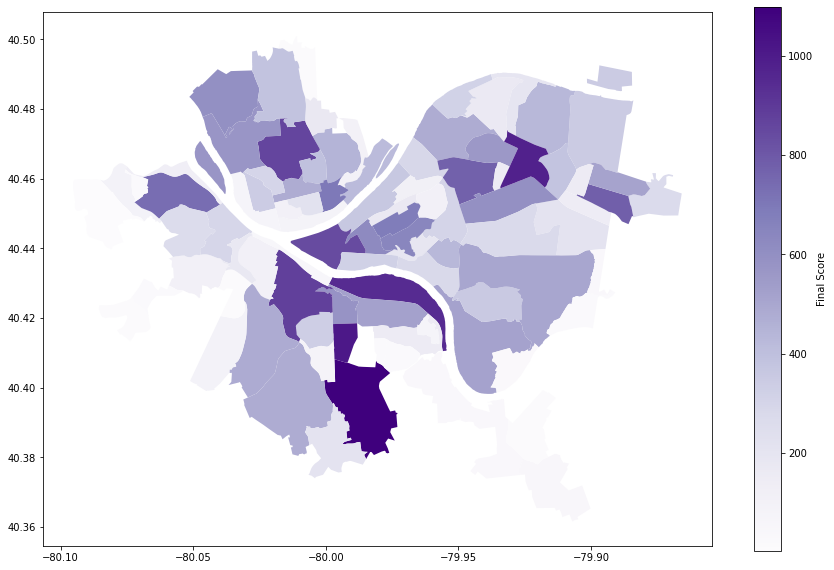

In [59]:
final_graph = best_neigh.groupby("Neighborhood").sum()['Final Score']
final_map = neighborhoods.merge(final_graph, how='left', left_on='hood', right_on='Neighborhood')
final_map.plot(column='Final Score',
                  cmap='Purples',
                  figsize=(15,10), 
                  legend=True,
                  legend_kwds={'label':"Final Score"}
                  )

---

## Metric #3: Housing

---

### We will now examine housing in Pittsburgh, specifically, the percentage of occupied units, the median home value, and the established average years of residence. These factors, out of all the factors in the dataset, were the top three ones, according to a survey we conducted on Google Forms.

## The Dataset

The pandas, numpy, geopandas, matplot and the housing CSV file are imported. The CSV is saved to the variable "data" as a pandas dataframe.

In [60]:
import pandas as pd
import numpy as np
import geopandas as geo
%matplotlib inline
import matplotlib.pyplot as plt
data = pd.read_csv("housing.csv", 
                                       index_col="Neighborhood")
data.head(10)

# % Occupied Units
# Median Home Value
# Est. Avg. Years of Residence

,Sector #,Population (2010),Total # Units (2000),Total # Units (2010),% Occupied Units (2010),% Vacant Units (2010),# Occupied Units (2010),% Owner Occupied Units (2010),% Renter Occupied Units (2010),Est. Avg. Yrs. of Residence (2010),...,% Units Built before 1939,Median Home Value (2000),Med. Val. ('00 in '10 Dollars),Median Home Value (2010),% Change Real Value 2000-2010,Median Sale Price (2010),# Sales Counted (2010),Foreclosures (2008),Foreclosures (2010),% of all Housing Units Foreclosed (2010)
Neighborhood,,,,,,,,,,,,,,,,,,,,,
Allegheny Center,3,933,675,"1,052",51.5%,48.5%,535,10.1%,89.9%,0,...,1.3%,"$86,500","$109,535","$136,300",24.4%,NaN,0,0,0,0.0%
Allegheny West,3,462,390,355,74.9%,25.1%,203,18.2%,81.8%,15,...,57.4%,"$159,700","$202,228","$123,600",-38.9%,"$309,940",7,0,1,0.3%
Allentown,6,"2,500","1,505","1,291",80.0%,20.0%,953,59.2%,40.8%,5,...,62.9%,"$34,300","$43,434","$42,200",-2.8%,"$8,500",70,27,11,0.9%
Arlington,7,"1,869",880,886,86.6%,13.4%,754,65.4%,34.6%,11,...,72.3%,"$38,800","$49,132","$44,200",-10.0%,"$15,397",34,12,13,1.5%
Arlington Heights,7,244,557,148,91.2%,8.8%,139,18.7%,81.3%,2,...,9.2%,"$45,000","$56,984","$64,400",13.0%,NaN,0,0,0,0.0%
Banksville,5,"4,144","2,203","2,118",95.4%,4.6%,"2,093",49.9%,50.1%,5,...,4.6%,"$87,200","$110,421","$110,900",0.4%,"$101,431",40,7,5,0.2%
Bedford Dwellings,15,"1,202","1,049",746,87.3%,12.7%,695,7.6%,92.4%,2,...,38.6%,"$17,200","$21,780","$81,100",272.4%,$200,1,0,1,0.1%
Beechview,5,"7,974","4,048","3,939",89.3%,10.7%,"3,518",58.7%,41.3%,6,...,42.7%,"$56,150","$71,103","$72,400",1.8%,"$36,068",128,64,40,1.0%
Beltzhoover,6,"1,925","1,298","1,085",73.5%,26.5%,849,73.5%,26.5%,17,...,67.4%,"$34,000","$43,054","$36,000",-16.4%,"$2,744",39,12,11,1.0%


This is a preview of our housing dataset. It consists of many different columns which provide information about housing in Pittsburgh.

## Percentage Occupied Units Analysis

There are a few things required to be done before the analysis of the first column, percentage of occupied units, can be analyzed. Firstly, the percentage symbol of each cell from this column is stripped away using rstrip() and the data is converted from a string to a float. This column is now numerical.

Next, a new dataframe called "units" is created which consists of two columns: the names of the Pittsburgh neighborhoods and the numerical values of the percentage of occupied units.

The mean is calculated, converted to a float, and saved to the variable, "mean".

The units dataframe now gets a third, blank column, which we will fill up with "Yes"s and "No"s.

Now, for the most important part, the analysis. For each row in the units table that we just created, the number is compared to the mean. However, as you can see, the mean is multiplied by a special number. This special number is simply the score we got from our survey, divided by 5, since you had to pick from a scale of 1 to 5 in the survey. The special number is multiplied to the mean so that it reduces. So if the mean was 50 and there were 20 neighborhoods with the percentage of occupied units below 50, for example, multiplying 50 by the special number, 4/5, will give 40 as the new mean. Now, only 15 neighborghoods will have a percentage of occupied units below 40. So, by doing this, we have created a table, where rows with a value significantly below the mean have a "Yes" next to them. These neighborhoods are the really good ones, statistically speaking.

Lastly, the finished table is printed along with the count, c.

In [61]:
# % Occupied Units
# Median Home Value (2010)
# Est. Avg. Years of Residence
#4.67816092
count = 0
for x in data["% Occupied Units (2010)"]:
     x = str(x).rstrip('%')
     data.iloc[count, 4] = float(x)
     count+=1

units = data.sort_values(by=['% Occupied Units (2010)'], ascending = False).iloc[0:, 4:5]

    
#mean is calculated
mean = float(units.mean())
print(mean*0.93)

units["Falls Below Avg Percentage Occupied Units?"] = np.nan
#only values a certain quantity less than the mean are printed
c = 0
for x in range(len(units)):
    #put the special fraction here, based on the survey (out of 5)
    temp = units.iloc[x,0]
    if (temp < mean*(4.67816092/5)):
        units.iloc[x,1] = "Yes"
        c+=1
    else:
        units.iloc[x,1] = "No:("
        
print(units.head(10))
print(c)

79.06446666666666
                    % Occupied Units (2010)  \
Neighborhood                                  
Chateau                                 100   
Swisshelm Park                         96.3   
Ridgemont                              95.9   
Banksville                             95.4   
Oakwood                                95.4   
Regent Square                          95.2   
Point Breeze                           95.1   
Glen Hazel                             94.8   
Squirrel Hill South                    94.6   
North Oakland                          94.5   

                    Falls Below Avg Percentage Occupied Units?  
Neighborhood                                                    
Chateau                                                   No:(  
Swisshelm Park                                            No:(  
Ridgemont                                                 No:(  
Banksville                                                No:(  
Oakwood                    

Here, a map is created using geopandas. The map represents the percentage of occupied units for each neighborhood in Pittsburgh. The map was created by merging the units table we previously created with the shape file of the Pittsburgh map.

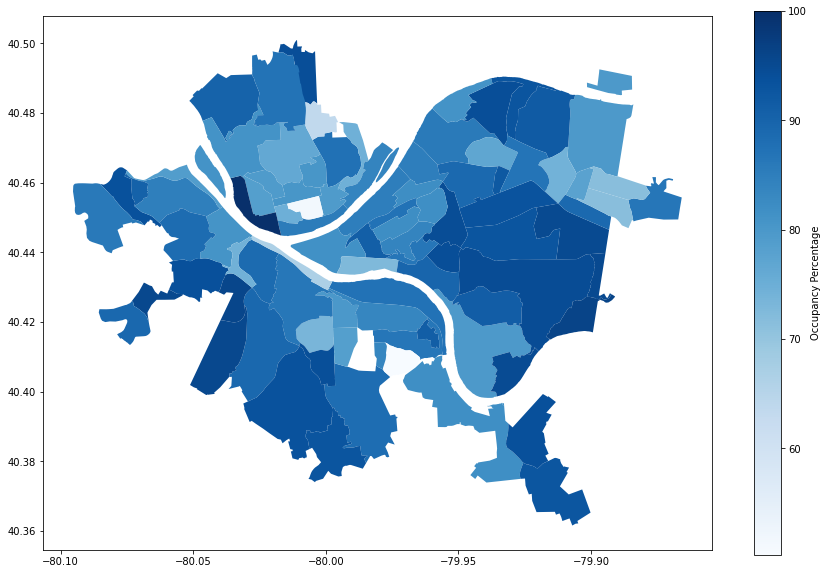

In [62]:
occ_series = units.groupby("Neighborhood").sum()['% Occupied Units (2010)']
neighborhoods = geo.read_file("Neighborhoods/Neighborhoods_.shp")
occ_map = neighborhoods.merge(occ_series, how='left', left_on='hood', right_on='Neighborhood')
occ_map.plot(column='% Occupied Units (2010)',
                  cmap='Blues',
                  figsize=(15,10), 
                  legend=True,
                  legend_kwds={'label':"Occupancy Percentage"}
                  )

## Median Home Value Analysis

The same process was repeated for median home value. The values were made numerical by removing the percentage symbol and commas, these values were put into a units table, the mean was calculated, and finally the data was analyzed by comparing it to the mean multiplied by the special number.

In [63]:
# 4.494252874
count = 0
for x in data["Median Home  Value (2010)"]:
    x = str(x).replace('$','')
    x = str(x).replace(',','')
    data.iloc[count, 20] = float(x)
    count+=1
    
mhv_units = data.sort_values(by=["Median Home  Value (2010)"], ascending=False).iloc[0:, 20:21]

mhv_mean = float(mhv_units.mean())
print(mhv_mean)

mhv_units["Falls Below Avg Median Home Value?"] = np.nan

c = 0
for x in range(len(mhv_units)):
    mhv_temp = mhv_units.iloc[x,0]
    if mhv_temp < mhv_mean*(4.494252874/5):
        mhv_units.iloc[x,1] = "Yes!"
        c+=1
    else:
        mhv_units.iloc[x,1] = "No :("
        
print(mhv_units.tail(20))
print(c)

89655.58823529411
                         Median Home  Value (2010)  \
Neighborhood                                         
Upper Lawrenceville                          48700   
Homewood South                               48400   
Spring Garden                                48000   
Arlington                                    44200   
Lincoln-Lemington-Belmar                     43767   
Allentown                                    42200   
St. Clair                                    41100   
East Hills                                   40700   
Knoxville                                    39900   
Beltzhoover                                  36000   
Homewood North                               35450   
Larimer                                      34850   
Homewood West                                34500   
West End                                     29800   
Bluff                                        21200   
Chateau                                        NaN   
Glen Hazel

The map was created for median home value using the same process as what we had done for percentage of occupied units.

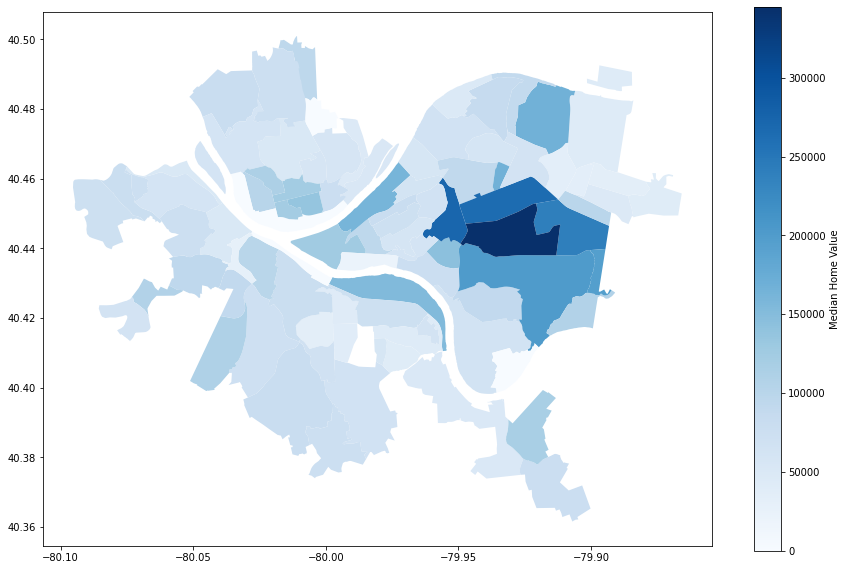

In [64]:
mhv_series = mhv_units.groupby("Neighborhood").sum()['Median Home  Value (2010)']
neighborhoods = geo.read_file("Neighborhoods/Neighborhoods_.shp")
mhv_map = neighborhoods.merge(mhv_series, how='left', left_on='hood', right_on='Neighborhood')
mhv_map.plot(column='Median Home  Value (2010)',
                    cmap='Blues',
                    figsize=(15,10),
                    legend=True,
                    legend_kwds={'label':"Median Home Value"})

## Established Average Years of Residence Analysis

The last metric in housing was establish average years of residence, and it was analyzed using the same process as the previous metrics.

In [65]:
# 3.425287356

count = 0
for x in data["Est. Avg. Yrs. of Residence (2010)"]:
    data.iloc[count, 9] = float(x)
    count+=1
    
yres_units = data.sort_values(by=["Est. Avg. Yrs. of Residence (2010)"], ascending=False).iloc[0:, 9:10]

yres_mean = float(yres_units.mean())

yres_units["Falls Below Est. Avg. Yrs. of Residence?"] = np.nan

c = 0
for x in range(len(yres_units)):
    yres_temp = yres_units.iloc[x,0]
    if yres_temp > yres_mean*(3.425287356/5):
        yres_units.iloc[x,1] = "Yes !"
        c+=1
    else:
        yres_units.iloc[x,1] = "No :("
        
print(yres_units.sample(20))
print(c)

                          Est. Avg. Yrs. of Residence (2010)  \
Neighborhood                                                   
Marshall-Shadeland                                       7.0   
Lower Lawrenceville                                      2.0   
Chateau                                                  0.0   
Greenfield                                               6.0   
Beechview                                                6.0   
Brighton Heights                                         5.0   
Lincoln Place                                           15.0   
Windgap                                                 13.0   
Fairywood                                                3.0   
Knoxville                                                8.0   
Homewood West                                            4.0   
Oakwood                                                  5.0   
Arlington                                               11.0   
East Carnegie                           

This is the map for established average years of residence in Pittsburgh.

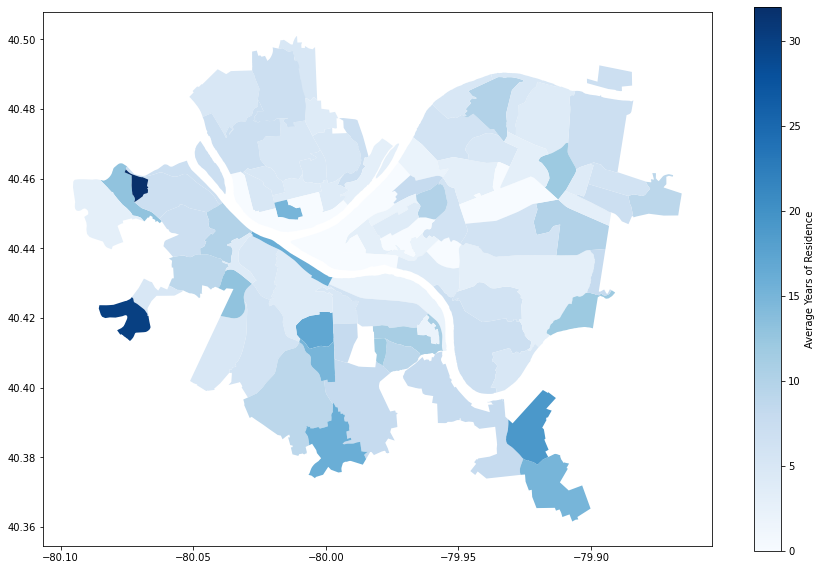

In [66]:
yres_series = yres_units.groupby("Neighborhood").sum()["Est. Avg. Yrs. of Residence (2010)"]
neighborhoods = geo.read_file("Neighborhoods/Neighborhoods_.shp")
yres_map = neighborhoods.merge(yres_series, how='left', left_on='hood', right_on='Neighborhood')
yres_map.plot(column='Est. Avg. Yrs. of Residence (2010)',
             cmap='Blues',
             figsize=(15,10),
             legend=True,
             legend_kwds={'label':"Average Years of Residence"}
             )

## Conclusion

In conclusion, after looking at all the results, Spring Garden, along with some other equally good neighborhoods, shows up in all three tables, making it the best neighborhood in Pittsburgh for housing!

74.6% of Spring Garden's houses are occupied, it has an average of 7 years of residence per house, and the cost is low, at roughly $48,000 for a house.

---

## Combined Results

Using the individual scores from the three metrics (transportation, health/safety and housing), we can now combine them into one massive score for each neighborhood, giving us the best neighborhoods overall. Transportation and housing scores are added to final scoring, while the health/safety scores are subtracted from final scoring (as a higher health/safety score means crime rates are higher).

In [67]:
combined_results = pd.concat([overall_scores.iloc[0:, 2:3], best_neigh.iloc[0:, 2:3]], axis=1, join='inner')
combined_results["Combined"] = np.nan
for x in range (len(overall_scores)):
    combined_results.iloc[x,2] = combined_results.iloc[x,0] - combined_results.iloc[x,1];
combined_results = combined_results.sort_values(by=['Combined'], ascending = False)
combined_results.head(8)

,Biking/Walking Scores,Crime Scores,Combined
Neighborhood,,,
Lower Lawrenceville,264.236111,72.0,192.236111
North Oakland,266.416667,76.0,190.416667
Friendship,211.347222,39.0,172.347222
Spring Garden,193.625000,24.0,169.625000
Central Oakland,216.666667,110.0,106.666667
Allegheny Center,152.083333,53.0,99.083333
Swisshelm Park,99.972222,6.0,93.972222
West Oakland,141.666667,48.0,93.666667


Here's a look at our final scores in Geopandas:

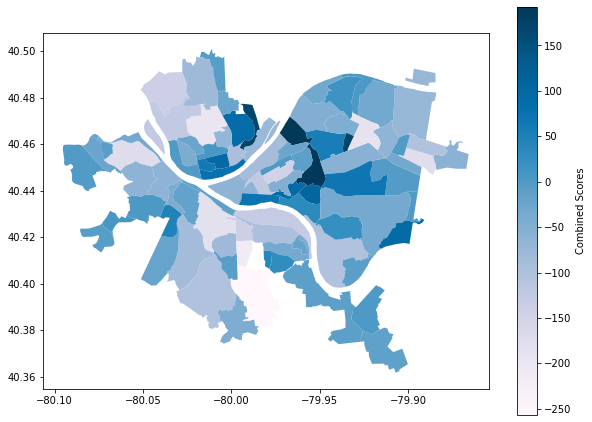

In [68]:
final_scores = combined_results.groupby("Neighborhood").sum()['Combined']
final_map = neighborhoods.merge(final_scores, how='left', left_on='hood', right_on='Neighborhood')
final_map.plot(column='Combined',
                  cmap='PuBu',
                  figsize=(10,7.5), 
                  legend=True,
                  legend_kwds={'label':"Combined Scores"})

# Final Conclusions